In [3]:
import numpy as np
import pandas as pd
import time
import memory_profiler
%load_ext memory_profiler
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
import NaiveDE
import SpatialDE


def get_coords(index):
    coords = pd.DataFrame(index=index)
    coords['x'] = index.str.split('x').str.get(0).map(float)
    coords['y'] = index.str.split('x').str.get(1).map(float)
    return coords


In [4]:
nc=[]
tt =[]
import time
import warnings
warnings.filterwarnings('ignore')


n_cell=[100,250,500,1000,1500,5000,10000,15000,50000]
for i in n_cell:
    ff='../../data/Simulation_data//1_million_cells_100genes_counts_0.csv'
    df_0 = pd.read_csv(ff,sep=',', index_col = 0, iterator=True)

    df=df_0.get_chunk(i)
    df = df.T[df.sum(0) >= 3].T   
   
    sample_info = get_coords(df.index)
    sample_info['total_counts'] = df.sum(1)
    sample_info = sample_info.query('total_counts > 10')  # Remove empty features
    

    df = df.loc[sample_info.index]     # Align count matrix with metadata table
    X = sample_info[['x', 'y']]

# Convert data to log-scale, and account for depth
    dfm = NaiveDE.stabilize(df.T).T
    res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

# Add total_count as pseudogene for reference
    res['log_total_count'] = np.log(sample_info['total_counts'])

# Perform Spatial DE test with default settings
    start=time.time()
    %memit results = SpatialDE.run(X, res)
    finish=time.time()
    t=finish-start                # 15706 
    
    nc.append(int(i))    
    tt.append(t/60)




peak memory: 199.74 MiB, increment: 26.76 MiB




peak memory: 207.69 MiB, increment: 7.07 MiB




peak memory: 231.10 MiB, increment: 28.66 MiB




peak memory: 322.93 MiB, increment: 115.89 MiB




peak memory: 474.71 MiB, increment: 257.57 MiB




peak memory: 2913.32 MiB, increment: 2681.34 MiB


In [7]:
n_cell

[100, 250, 500, 1000, 1500, 5000]

In [8]:
tt

[0.06700764497121176,

 0.08040995200475057,

 0.0879809300104777,

 0.12168582280476888,

 0.17430559396743775,

 1.3808773318926493]

In [6]:
memory=[199.74, 207.69, 231.10, 322.93, 474.71, 2913.32 ]

In [25]:
df=pd.DataFrame({'n.cells':nc,'n.genes':100,'time_mins':tt,'memory_MiB':memory})
df

,n.cells,n.genes,time_mins,memory_MiB
0,100,100,0.067008,199.74
1,250,100,0.080410,207.69
2,500,100,0.087981,231.10
3,1000,100,0.121686,322.93
4,1500,100,0.174306,474.71
5,5000,100,1.380877,2913.32


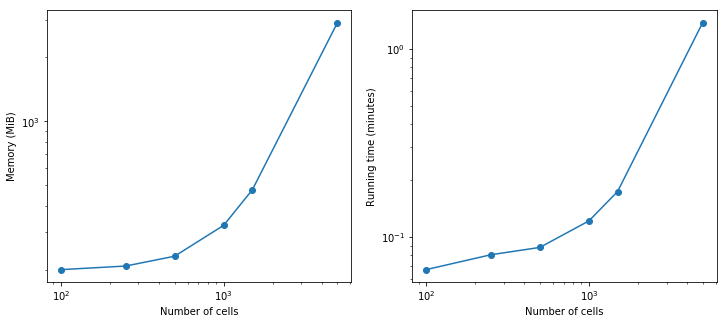

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(n_cell, memory, marker = 'o')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('Number of cells')
ax[0].set_ylabel('Memory (MiB)')


ax[1].plot(n_cell, tt, marker = 'o')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('Number of cells')
ax[1].set_ylabel('Running time (minutes)')

#plt.savefig('../../results//spatialDE_running_time_code_ocean.pdf')
plt.show()